In [1]:
import pandas as pd
import numpy as np
import pygsp as pg
from sklearn.cluster import KMeans
import networkx as nx
from scipy import sparse
import matplotlib.pyplot as plt
import scipy.sparse.linalg
from pyunlocbox import functions, solvers

# Exposing the True Terrorist Network

In the context of social network analysis, where social networks are generally represented as a graph where nodes are individuals and edges are relationships, frequently the primary objective is to predict the existence of yet unobserved relationships. An implementation of such is Facebook's friend recommendation system.

In this project we work with the Terrorist Relations dataset that is taken from the Profile in Terror (PIT) knowledge base. This dataset illustrates an affiliation network of terrorists where nodes are represented as relations and edges as terrorists. As such, a node consists of two terrorist identifiers and two nodes are connected by an edge if they share a common terrorist. This representation is known as a Line Graph and is often used in classification tasks where the interest is placed on the label of two interlinked network entities rather than the labels of the entities themselves.

As terrorists arguably present the largest threat to today's society, it is of great interest to analyse and reveal interesting properties of their network in order to guide anti-terrorist campaigns and help ensure public safety around the world. This dataset was of particular interest as data relating to terrorists is scarce due to the secretive nature of terrorist activities. The original PIT dataset contains relevant terrorism related information extracted from public news sources such as newspapers, broadcasts, and court proceedings. Hence, this dataset is purely built on empirical evidences and it safe to assume that it is incomplete.

As a result, we set ourselves the objective of revealing the complete terrorist network and subsequently performing a network analysis on both the original and expanded networks. Finally, we aim to define the top priority terrorist(s) for anti-terrorism campaigns to target in order to successfully disrupt and weaken the network.

## I. Data Exploration and Pre-processing

The following cells load only the Colleague, Family, Congregate and Contact nodes datasets. Both the labels and edges datasets were left out. We did not load the label data as label information is already contained within the nodes data loaded below. Additionally, during the Milestones we discovered inconsistencies in the edges dataset (i.e. edges connecting non-existent nodes). Hence, we decided to leave it out and reconstruct the edges from the nodes data as seen later.

In [2]:
family = pd.read_csv('TerroristRel/TerroristRel_Family.nodes', header = None, delim_whitespace = True, engine='python')
colleague = pd.read_csv('TerroristRel/TerroristRel_Colleague.nodes', header = None, delim_whitespace = True, engine='python')
congregate = pd.read_csv('TerroristRel/TerroristRel_Congregate.nodes', header = None, delim_whitespace = True, engine='python')
contact = pd.read_csv('TerroristRel/TerroristRel_Contact.nodes', header = None, delim_whitespace = True, engine='python')

### a. Data structure

Looking at the nodes data below we can see that for all 4 datasets we have the following information:
-  Column 0: Concatenatation of the URL identifier of both terrorists in the relation
-  Column 1 to 1224: A set of binary features for each relation
-  Column 1225: The dataset's respective label indicator column that states if it is positively labeled or negatively labeled (i.e. family or non-family)

In [3]:
display(family.iloc[:1])
display(colleague.iloc[:1])
display(congregate.iloc[:1])
display(contact.iloc[:1])

,0,1,2,3,4,5,6,7,8,9,...,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225
0,http://profilesinterror.mindswap.org/document/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,family


,0,1,2,3,4,5,6,7,8,9,...,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225
0,http://profilesinterror.mindswap.org/document/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,colleague


,0,1,2,3,4,5,6,7,8,9,...,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225
0,http://profilesinterror.mindswap.org/document/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,congregate


,0,1,2,3,4,5,6,7,8,9,...,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225
0,http://counterterror.mindswap.org/2005/terrori...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,contact


We first verify whether the information contained in these datasets is identical excluding the label indicator column.

In [4]:
#ensure that they are all sorted in the same order
colleague_sorted = colleague.sort_values(0)
contact_sorted = contact.sort_values(0)
family_sorted = family.sort_values(0)
congregate_sorted = congregate.sort_values(0)

In [5]:
#retain all but last column
all_features = [colleague_sorted.iloc[:,1:1225], contact_sorted.iloc[:,1:1225], 
                family_sorted.iloc[:,1:1225], congregate_sorted.iloc[:,1:1225]]

In [6]:
def all_equal(iterator):
    for i in range(len(iterator)):
        for j in range(len(iterator)-i):
            if i == j:
                continue
            if np.array_equal(iterator[i], iterator[j]):
                continue
            else:
                return False
    return True

In [7]:
all_equal(all_features)

True

Hence we can confirm that the data is structured inefficiently and that the colleague, family, congregate and contact nodes data can be aggregated into one table. 

In [8]:
#only keep id/label information for family, congregate and contact datasets
family = family[[0, 1225]]
congregate = congregate[[0, 1225]]
contact = contact[[0, 1225]]
#rename columns
colleague = colleague.rename(columns={0: 'url_id', 1225: 'colleague'})
family = family.rename(columns={0: 'url_id', 1225: 'family'})
congregate = congregate.rename(columns={0: 'url_id', 1225: 'congregate'})
contact = contact.rename(columns={0: 'url_id', 1225: 'contact'})

In [9]:
#create table containing all feature and label information for each node
family = family.set_index('url_id')
congregate = congregate.set_index('url_id')
contact = contact.set_index('url_id')

nodeFeatures = colleague.join(family, on='url_id')
nodeFeatures = nodeFeatures.join(congregate, on='url_id')
nodeFeatures = nodeFeatures.join(contact, on='url_id')

In [10]:
#change labels into binary 0/1
nodeFeatures.loc[nodeFeatures['colleague'] == 'colleague', 'colleague'] = 1
nodeFeatures.loc[nodeFeatures['colleague'] == 'non-colleague', 'colleague'] = 0
nodeFeatures.loc[nodeFeatures['family'] == 'family', 'family'] = 1
nodeFeatures.loc[nodeFeatures['family'] == 'non-family', 'family'] = 0
nodeFeatures.loc[nodeFeatures['congregate'] == 'congregate', 'congregate'] = 1
nodeFeatures.loc[nodeFeatures['congregate'] == 'non-congregate', 'congregate'] = 0
nodeFeatures.loc[nodeFeatures['contact'] == 'contact', 'contact'] = 1
nodeFeatures.loc[nodeFeatures['contact'] == 'non-contact', 'contact'] = 0

Now the variable *nodeFeatures* contains all feature and label information for each node/relation in the terrorist relations network.

In [11]:
nodeFeatures.head()

,url_id,1,2,3,4,5,6,7,8,9,...,1219,1220,1221,1222,1223,1224,colleague,family,congregate,contact
0,http://profilesinterror.mindswap.org/document/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,http://profilesinterror.mindswap.org/document/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,http://profilesinterror.mindswap.org/document/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,http://profilesinterror.mindswap.org/document/...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,http://profilesinterror.mindswap.org/document/...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


We can also observe below, that initally it appears that we have mutually exlusive labels. This means that every relation is either labeled colleague, family, congregate or contact. However, we will see later on that this isn't the case.

In [12]:
len(np.where(np.sum(np.array(nodeFeatures.iloc[:,1225:]), axis=1)==1)[0])

851

### b. Data parsing

As the *nodeFeatures* dataset currently holds all the information we have, in the following cells we create new reference tables that capture a subset of its data:
-  *terrorists*: contains all unique terrorists in our dataset and for each terrorist it lists his original url_id, a newly assigned numerical id and his name (when one can be found in the url_id) 
-  *relations*: captures all the data in *nodeFeatures* except for the binary feature columns and has a separate column for each terrorist in the relation listing their respective name and numerical id

In [13]:
terrorists = []
relations = []

for i in range(len(nodeFeatures.iloc[:,0])):
    parsedNode = nodeFeatures.iloc[:,0].iloc[i].split('_http')
    parsedNode[1] = 'http' + parsedNode[1]
    
    relations.append((nodeFeatures.iloc[:,1225][i], nodeFeatures.iloc[:,1226][i],
                      nodeFeatures.iloc[:,1227][i], nodeFeatures.iloc[:,1228][i], parsedNode[0], parsedNode[1]))
    
    firstPerson = parsedNode[0].rsplit('#',1)[1]
    secondPerson = parsedNode[1].rsplit('#',1)[1]
    
    if firstPerson == '':
        firstPerson = parsedNode[0].split('/',4)[-1]
    if secondPerson == '':
        secondPerson = parsedNode[1].split('/',4)[-1]
     
    terrorists.append((parsedNode[0], firstPerson))
    terrorists.append((parsedNode[1], secondPerson))
    
terrorists = np.unique(terrorists, axis=0)

In [14]:
terrorists = pd.DataFrame(terrorists)
terrorists.reset_index(level=0, inplace=True)
terrorists = terrorists.rename(columns={'index':'num_index', 0:'url_index', 1:'name'})
terrorists = terrorists.set_index('url_index')
terrorists.head()

,num_index,name
url_index,,
http://counterterror.mindswap.org/2005/terrorists.owl#Abdel_Qader_Mahmoud_Es_Sayed,0,Abdel_Qader_Mahmoud_Es_Sayed
http://counterterror.mindswap.org/2005/terrorists.owl#Abderraouf_Hannachi,1,Abderraouf_Hannachi
http://counterterror.mindswap.org/2005/terrorists.owl#Abdul_Haim_Murad,2,Abdul_Haim_Murad
http://counterterror.mindswap.org/2005/terrorists.owl#Ahmed_Said_Khadr,3,Ahmed_Said_Khadr
http://counterterror.mindswap.org/2005/terrorists.owl#Amar_Makhulif,4,Amar_Makhulif


In [15]:
relations = pd.DataFrame(relations)
relations = relations.rename(columns={0:'colleague', 1:'family', 2:'congregate', 3:'contact', 
                                      4:'url_index_1', 5:'url_index_2' })
relations = relations.join(terrorists, on='url_index_1', how='left')
relations = relations.join(terrorists, on='url_index_2', rsuffix = '_2', how='left')
relations = relations.rename(columns={'num_index': 'num_index_1', 'name':'name_1'})
relations['rel_url'] = relations['url_index_1'] + '_' + relations['url_index_2']
relations = relations.drop(columns=['url_index_1', 'url_index_2'])

In [16]:
relations = relations[['colleague', 'family', 'congregate', 'contact', 'num_index_1', 'num_index_2',
                       'name_1', 'name_2', 'rel_url']]
relations.head()

,colleague,family,congregate,contact,num_index_1,num_index_2,name_1,name_2,rel_url
0,1,0,0,0,231,63,UmarBaziyani,Saif_Aldin_Mustafa_Nuaimi,http://profilesinterror.mindswap.org/document/...
1,1,0,0,0,62,63,Muhammad_Daham_Abu_Hamadi,Saif_Aldin_Mustafa_Nuaimi,http://profilesinterror.mindswap.org/document/...
2,1,0,0,0,60,63,Abu_Karrar,Saif_Aldin_Mustafa_Nuaimi,http://profilesinterror.mindswap.org/document/...
3,1,0,0,0,59,63,Abu_Jalal_Iraqi,Saif_Aldin_Mustafa_Nuaimi,http://profilesinterror.mindswap.org/document/...
4,1,0,0,0,232,61,Zarqawi,Abu_Obaida_Kubaisi,http://profilesinterror.mindswap.org/document/...


Additionally, as the Terrorist Relations dataset provides no information on the meaning of the present binary features we attempted to collect more information on these by searching online. We came across a paper (referenced in our report) that stated that the 1224 binary features actually consisted of 2 sets of 612 distinct features. The first 612 relate to the first terrorist in the relation and the remaining for the second. As such, we verified whether this statement was correct. In the cells below, we split the sets of features as described and assign them to their respective terrorist. The number of unique combinations of terrorist name/id and 612 features matches the number of entries in the *terrorists* table validating this understanding.

In [17]:
relationsCopy = relations.copy()
relationsCopy.reset_index(level=0, inplace=True)
relationsCopy = relationsCopy.set_index('rel_url')
relationsCopy = relationsCopy.drop(columns=['colleague', 'family', 'congregate', 'contact', 'index'])

In [18]:
nodeFeatures = nodeFeatures.join(relationsCopy, on='url_id', how='left')

In [19]:
features_set1 = list(range(1,613))
features_set1.insert(0, 1229)
features_set1.insert(0, 1231)
features_set2 = list(range(613,1225))
features_set2.insert(0, 1230)
features_set2.insert(0, 1232)

In [20]:
features_set1 = nodeFeatures.iloc[:,features_set1].drop_duplicates()
features_set2 = nodeFeatures.iloc[:,features_set2].drop_duplicates()
features_set1.columns = np.arange(len(features_set1.columns))
features_set2.columns = np.arange(len(features_set2.columns))

In [21]:
terrorist_features = pd.concat([features_set1, features_set2], sort=False)
terrorist_features = terrorist_features.drop_duplicates()
terrorist_features = terrorist_features.set_index(0)
terrorist_features = terrorist_features.sort_values(by=[1])
terrorist_features = terrorist_features.rename(columns={1: 'num_index'})

In [22]:
terrorist_features.head()

,num_index,2,3,4,5,6,7,8,9,10,...,604,605,606,607,608,609,610,611,612,613
0,,,,,,,,,,,,,,,,,,,,,
Abdel_Qader_Mahmoud_Es_Sayed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abderraouf_Hannachi,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abdul_Haim_Murad,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ahmed_Said_Khadr,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Amar_Makhulif,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### c. Dual graph

From our newly constructed datasets, it is now simple to construct the dual of our graph. The dual has nodes as terrorists and edges as relations as opposed to our original Link Graph. The dual graph shares the traditional structure of social network graphs and is equivalent to our initial Terrorist Relations network. It will be useful for our network analyses later on. We construct it in the cells below.

In [23]:
n_nodes = len(terrorists)
adjacency_dual = np.zeros((n_nodes, n_nodes), dtype=int)

In [24]:
for idx, row in relations.iterrows():
    i, j = int(row.num_index_1), int(row.num_index_2)
    adjacency_dual[i, j] = 1
    adjacency_dual[j, i] = 1

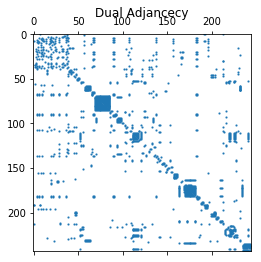

In [25]:
plt.title('Dual Adjancecy')
plt.spy(adjacency_dual, markersize=1)
plt.show()

Since the dual graph has nodes as terrorists and edges as relations we expected 244 nodes (number of rows in *terrorists*) and 851 edges (number of rows in *relations*). However, we observed that there was in fact 840 edges in our dual graph indicating that some of the relationships in the variable *relations* and the original dataset were actually mirrored (i.e. A<->B & B<->A). This also suggests the existence of multi-labels for relationships.

In [26]:
sum(sum(adjacency_dual))/2

840.0

### d. Edges from Nodes

As mentioned when loading the datasets, we encountered inconsistencies in the supplied edges dataset during the milestones and decided to construct the edges ourselves from the nodes data. This was feasible since we have a Link Graph. This means our nodes are relations between two terrorists and two nodes share an edge if they share a terrorist. We also removed those relationships that are mirrored (11) to construct a Link Graph with a reduced number of nodes (840). With this logic we constructed the edges in the cells below.

In [27]:
#get indices of mirrored relations and get unique list of relations
containerSet = set()
dupes1 = []

for i in range(relations.shape[0]):
    setSize = len(containerSet)
    containerSet.add(frozenset((relations.iloc[i,4], relations.iloc[i,5])))
    if len(containerSet) == setSize:
        dupes1.append(i)
    
relations_array = np.delete(np.array(relations)[:,4:6], dupes1, axis=0)

In [28]:
print('Number of mirrored relations:', len(dupes1))

Number of mirrored relations: 11


In [29]:
#flip terrorists in mirrored relations and get indices of their duplicates
mirrors = np.vstack((np.array(relations.iloc[dupes1])[:,5],np.array(relations.iloc[dupes1])[:,4])).T
mirrors = [list(x) for x in mirrors]
allRels = [list(x) for x in np.array(relations.iloc[:,4:6])]

dupes2 = []
for i in range(len(allRels)):
    if allRels[i] in mirrors:
        dupes2.append(i)

In [30]:
#generate edges from relations_array above
edges= set()
for i in range(len(relations_array)):
    for j in range(len(relations_array)):
        if i == j:
            continue
        for e in range(0,2):
            if relations_array[i][e] in list(relations_array[j]):
                edges.add(frozenset((i,j)))
                
edges = [list(x) for x in edges]

Construct adjacency of our original network with unique nodes (i.e. unique relations)

In [31]:
adjacency = np.zeros((len(relations_array), len(relations_array)))

for p in edges:
    adjacency[p[0],p[1]] = 1
    adjacency[p[1],p[0]] = 1

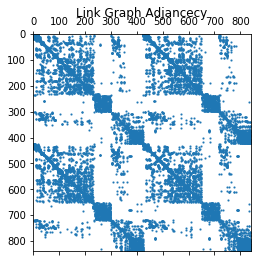

In [32]:
plt.title('Link Graph Adjancecy')
plt.spy(adjacency, markersize=1)
plt.show()

### e. Data restructuring

As we have identified that there are duplicate relations in our *relations* variable, we want to remove these and aggregate their label information in one entry. Therefore, we create the *relations_compact* variable that contains 840 unique relations and those rows where the relations were mirrored will now have multiple labels.

In [33]:
#flip mirrored relations to match their original
newData = []
for i in range(relations.shape[0]):
    if i in dupes1:
        relInfo = list(relations.iloc[i,0:4])
        relInfo.append(relations.iloc[i,5])
        relInfo.append(relations.iloc[i,4])
        relInfo.append(relations.iloc[i,7])
        relInfo.append(relations.iloc[i,6])
        relInfo.append(relations.iloc[i,8])
        newData.append(relInfo)
    else:
        newData.append(list(relations.iloc[i]))

In [34]:
#for duplicate relations aggregate label info into one row and remove the other
for i in dupes1:
    for j in dupes2:
        if list(newData[i][4:6]) == list(newData[j][4:6]):
            newData[j][0] = newData[j][0] + newData[i][0]
            newData[j][1] = newData[j][1] + newData[i][1]
            newData[j][2] = newData[j][2] + newData[i][2]
            newData[j][3] = newData[j][3] + newData[i][3]
            
newData = [i for j, i in enumerate(newData) if j not in dupes1]

In [35]:
relations_compact = pd.DataFrame(newData)
relations_compact = relations_compact.rename(columns={0:'colleague', 1:'family', 2:'congregate', 3:'contact',
                                          4:'num_index_1', 5:'num_index_2', 6:'name_1', 7:'name_2', 8:'rel_url' })
relations_compact.iloc[dupes2].head()

,colleague,family,congregate,contact,num_index_1,num_index_2,name_1,name_2,rel_url
51,1,0,0,1,213,39,Zawahiri,OBL,http://profilesinterror.mindswap.org/document/...
159,1,0,0,1,18,14,Moulad_Bouguelane,Lionel_Dumont,http://counterterror.mindswap.org/2005/terrori...
162,1,0,0,1,40,41,AhmadAjaj,EyadIsmoil,http://profilesinterror.mindswap.org/document/...
167,1,0,0,1,221,224,FathiKhatib,NasserWatimi,http://profilesinterror.mindswap.org/document/...
191,1,1,0,0,194,193,2006/02/02/16:11:52#,2006/02/02/16:03:38#,http://profilesinterror.mindswap.org/document/...


## II. Data Analysis

### a. Feature Set Reduction

To make efficient use of the 612 terrorist features we have available, we reduce this set in the cells below by removing those features that are 0 for all 244 terrorists and keeping one feature in a group of features that pairwise have a correlation coefficent above 0.9

In [36]:
binary_features = np.array(terrorist_features.iloc[:,1:613])

In [37]:
#get index of features that are 0 for all rows and remove them
nonzero_cols = np.where(sum(binary_features)!=0)[0]
binary_features = binary_features[:,nonzero_cols]

#compute correlation matrix of remaining features
feature_correlation = np.corrcoef(binary_features.astype(float), rowvar=False)

#create adjacency matrix with 1 in entry i,j IF i!=j && i and j are highly +ly/-ly correlated
relFeatures = np.absolute(feature_correlation) > 0.9
relFeatures = relFeatures.astype(int)
np.fill_diagonal(relFeatures,0)

#extract one feature from each group of highly correlated features
correlated_components = [list(x) for x in list(nx.connected_components(nx.from_numpy_matrix(relFeatures)))]
definingFeatures = [comp[0] for comp in correlated_components]

featuresReduced = binary_features[:,definingFeatures]

We now have 440 binary features per terrorist instead of 612

In [38]:
featuresReduced.shape

(244, 440)

### b. Expand terrorist network

As we have stated, it is safe to assume that the Terrorist Relations dataset we are working is incomplete. This is due to the fact that the relations between terrorists we have so far are only the ones that have been observed in reality. Therefore, it is highly likely that some terrorists that appear to be unrelated actually are. As we cannot come up with new individuals, we can instead estimate which pair of terrorists know each other based on the similarity of their binary features.

Since we know that the relations we already have definitely exist, we aim to enrich our dataset with potential additional relations. This means we keep our original dual adjacency and only add edges to it if two previously unrelated terrorists appear to share similar features. To determine similarity between terrorist, we only looked at those terrorists that have at least 3 positive binary features (since many of these are set to 0) and added a new edge if the binary features for a pair of terrorists had a correlation coefficient above 0.5 

In [39]:
T_WithFeatures = np.where(sum(featuresReduced.T) >= 3)[0]
T_correlation = np.corrcoef(featuresReduced[T_WithFeatures].astype(float))

In [40]:
correlated_terrorists = np.where(T_correlation>0.5)
correlated_terrorists = list(zip(correlated_terrorists[0], correlated_terrorists[1]))
correlated_terrorists = [[T_WithFeatures[x[0]], T_WithFeatures[x[1]]] for x in correlated_terrorists if x[0]!=x[1]]

In [41]:
new_edges = []
adjacency_dual_expanded = adjacency_dual.copy()
for k in correlated_terrorists:
    if adjacency_dual_expanded[k[0], k[1]] != 1 and adjacency_dual_expanded[k[1], k[0]] != 1:
        adjacency_dual_expanded[k[1], k[0]] = 1
        adjacency_dual_expanded[k[0], k[1]] = 1
        new_edges.append(k)

In [42]:
print('Original dual adjacency edges:', int(sum(sum(adjacency_dual))/2))
print('Expanded dual adjacency edges:', int(sum(sum(adjacency_dual_expanded))/2))
print('New edges/Terrorist connections:', len(new_edges))
print('Network size increase:', int(len(new_edges)*100/(sum(sum(adjacency_dual))/2)), '%')

Original dual adjacency edges: 840
Expanded dual adjacency edges: 945
New edges/Terrorist connections: 105
Network size increase: 12 %


Now our network has grown from 840 unique relations to 945. This illustrates that the true terrorist network could at least be 12% larger than what we think purely based on similarity of terrorist features!

We now create a table in the *relations_expanded* variable that has all the newly created relations in addition to the ones in *relations_compact*

In [43]:
terrorists.reset_index(level=0, inplace=True)
terroristDictionary = terrorists.drop(columns=['num_index']).to_dict()

In [44]:
newEdgesDF = pd.DataFrame([[0, 0, 0, 0, x[0], x[1], 
                            terroristDictionary['name'][x[0]], 
                            terroristDictionary['name'][x[1]], 
                            terroristDictionary['url_index'][x[0]] + '_' + terroristDictionary['url_index'][x[1]]] 
                           for x in new_edges])

newEdgesDF.columns = ['colleague', 'family', 'congregate', 'contact', 
                      'num_index_1', 'num_index_2', 'name_1', 'name_2', 'rel_url']

In [45]:
newEdgesDF.columns = ['colleague', 'family', 'congregate', 'contact', 
                      'num_index_1', 'num_index_2', 'name_1', 'name_2', 'rel_url']

In [46]:
relations_expanded = pd.concat([relations_compact, newEdgesDF])
relations_expanded.reset_index(level=0, inplace=True)
relations_expanded = relations_expanded.drop(columns=['index'])
relations_expanded.tail()

,colleague,family,congregate,contact,num_index_1,num_index_2,name_1,name_2,rel_url
940,0,0,0,0,76,148,Nouredine_el_Fahtni,2005/12/02/04:22:51#,http://profilesinterror.mindswap.org/document/...
941,0,0,0,0,107,148,2005/09/07/09:36:59#,2005/12/02/04:22:51#,http://profilesinterror.mindswap.org/document/...
942,0,0,0,0,129,147,2005/10/31/18:01:07#,2005/12/02/04:08:41#,http://profilesinterror.mindswap.org/document/...
943,0,0,0,0,198,209,2006/02/15/18:45:00#,2006/03/28/16:33:37#,http://profilesinterror.mindswap.org/document/...
944,0,0,0,0,209,234,2006/03/28/16:33:37#,King_Fahd,http://profilesinterror.mindswap.org/document/...


Generating new edges in our dual graph is equivalent to creating new nodes in our original Link Graph. We construct the expanded adjacency for our original graph in the cells below

In [47]:
#take only num ids of terrorist relations from relations_expanded
relations_array_expanded = np.array(relations_expanded)[:,4:6]

In [48]:
edges_expanded= set()
for i in range(len(relations_array_expanded)):
    for j in range(len(relations_array_expanded)):
        if i == j:
            continue
        for e in range(0,2):
            if relations_array_expanded[i][e] in list(relations_array_expanded[j]):
                edges_expanded.add(frozenset((i,j)))
                
edges_expanded = [list(x) for x in edges_expanded]

In [49]:
adjacency_expanded = np.zeros((len(relations_array_expanded), len(relations_array_expanded)))

for p in edges_expanded:
    adjacency_expanded[p[0],p[1]] = 1
    adjacency_expanded[p[1],p[0]] = 1

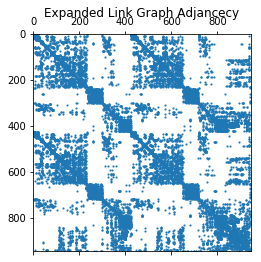

In [50]:
plt.title('Expanded Link Graph Adjancecy')
plt.spy(adjacency_expanded, markersize=1)
plt.show()

### c. Label interpolation for new relations

Now that we have augmented our dual graph based on terrorist features and subsequently expanded our original Link Graph, we now have a set of new unlabeled relations. These unlabeled relations roughly represent 10% of our new expanded graph. This is gives us the opportunity to perform signal interpolation for each of our labels, represented as separate signals. We took a one-vs-all approach for each and used the p-2 norm as it returned better results during the Milestones. Additionally, we leveraged the 'black-box' solver given in Milestone 4. 

In [51]:
def graph_pnorm_interpolation(gradient, P, x0=None, p=1., **kwargs):
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

In [52]:
mask = np.zeros(relations_expanded.shape[0])
np.put(mask, list(range(840)), 1)

In [53]:
def PS(sig):
    def P(a):
        b = np.zeros(relations_expanded.shape[0])
        b = b + np.multiply(mask, sig)
        b = b + np.multiply(abs(abs(mask)-1), a)
        return b
    return P

In [54]:
gradient = nx.incidence_matrix(nx.from_numpy_matrix(adjacency_expanded), oriented=True).T

In [55]:
label_signals = []
for i in range(4):
    signal = np.array(relations_expanded.iloc[0:840:,i], dtype=float)
    signal[signal==0] = -1
    signal = np.append(signal, np.zeros(105))

    sol_2norm_min = graph_pnorm_interpolation(sparse.csr_matrix(gradient), PS(signal), signal, p=2.)

    threshold = 0

    sol_2norm_bin = np.array(sol_2norm_min)
    sol_2norm_bin[sol_2norm_bin>threshold] = 1
    sol_2norm_bin[sol_2norm_bin<threshold] = 0
    
    label_signals.append(sol_2norm_bin)

Solution found after 1 iterations:
    objective function f(sol) = 4.115310e+03
    stopping criterion: RTOL
Solution found after 200 iterations:
    objective function f(sol) = 1.042370e+03
    stopping criterion: MAXIT
Solution found after 1 iterations:
    objective function f(sol) = 2.401030e+03
    stopping criterion: RTOL
Solution found after 1 iterations:
    objective function f(sol) = 4.960373e+03
    stopping criterion: RTOL


In [56]:
label_signals = np.array(label_signals)

In [57]:
relations_expanded_rich = relations_expanded.copy()
relations_expanded_rich['colleague'] = label_signals[0].astype(int)
relations_expanded_rich['family'] = label_signals[1].astype(int)
relations_expanded_rich['congregate'] = label_signals[2].astype(int)
relations_expanded_rich['contact'] = label_signals[3].astype(int)

In [58]:
for i in range(len(relations.columns[:4])):
    print(relations.columns[i], 
          ': \t - original:', 
          sum(relations.iloc[:,i]), 
          '\t - expanded:', 
          sum(relations_expanded_rich.iloc[:,i]), 
          '\t - increase:',
          int((sum(relations_expanded_rich.iloc[:,i]) - sum(relations.iloc[:,i]))*100/sum(relations.iloc[:,i])), 
          '%\n')

colleague : 	 - original: 461 	 - expanded: 513 	 - increase: 11 %

family : 	 - original: 136 	 - expanded: 138 	 - increase: 1 %

congregate : 	 - original: 106 	 - expanded: 144 	 - increase: 35 %

contact : 	 - original: 148 	 - expanded: 157 	 - increase: 6 %



We can see above that the expansion was proprotionally most remarkable in the terrorist network of congregates

### d. Clustering

Now that we have expanded the terrorist network and learned the labels of the new relations, we investigate into how this impacts the clustering performance. We take the clustering we performed in Milestone 3 below

In [59]:
#Extract Biggest Connected Component
clustered_adjacencies = []
accuracies = []
for a in [[adjacency, relations_compact], [adjacency_expanded, relations_expanded_rich]]:
    GCC = max(nx.connected_component_subgraphs(nx.from_numpy_matrix(a[0])), key=len)
    GCC_nodes = np.array(GCC.nodes())
    GCC = nx.to_numpy_matrix(GCC)
    GCC = np.squeeze(np.asarray(GCC))
    
    GCC_laplacian =  scipy.sparse.csgraph.laplacian(GCC, normed=False)
    GCC_sparseLapla = sparse.csr_matrix(GCC_laplacian)
    GCC_csrLapla = GCC_sparseLapla.tocsr()
    
    GCC_egval, GCC_egvec = scipy.sparse.linalg.eigsh(GCC_csrLapla, 3, which='SM')
    GCC_egvec = np.delete(GCC_egvec, 0, 1) #remove eigenvector associated to eigenvalue 0
    
    Kmeans = KMeans(n_clusters=4).fit(GCC_egvec)
    
    c1 = np.squeeze(np.take(GCC_egvec, np.where(Kmeans.labels_==0), 0))
    c2 = np.squeeze(np.take(GCC_egvec, np.where(Kmeans.labels_==1), 0))
    c3 = np.squeeze(np.take(GCC_egvec, np.where(Kmeans.labels_==2), 0))
    c4 = np.squeeze(np.take(GCC_egvec, np.where(Kmeans.labels_==3), 0))
    
    GCC_adj = a[0][np.ix_(GCC_nodes, GCC_nodes)]
    
    GCC_clust_adj = np.vstack((GCC_adj[np.where(Kmeans.labels_==0)], 
                               GCC_adj[np.where(Kmeans.labels_==1)], 
                               GCC_adj[np.where(Kmeans.labels_==2)], 
                               GCC_adj[np.where(Kmeans.labels_==3)]))
    
    GCC_clust_adj = np.hstack((np.squeeze(GCC_clust_adj[:,np.where(Kmeans.labels_==0)]), 
                               np.squeeze(GCC_clust_adj[:,np.where(Kmeans.labels_==1)]), 
                               np.squeeze(GCC_clust_adj[:,np.where(Kmeans.labels_==2)]), 
                               np.squeeze(GCC_clust_adj[:,np.where(Kmeans.labels_==3)])))
    
    clustered_adjacencies.append(GCC_clust_adj)
    
    relations_array = np.array(a[1])
    relations_array = np.take(relations_array, GCC_nodes, axis=0)
    
    clusters = []
    for i in range(4):
        clusters.append(np.where(relations_array[:,i] == 1)[0])

    accuracy = []
    for ind in clusters:
        cont = []
        for j in range(4):
            cont.append(round(list(np.isin(ind, np.where(Kmeans.labels_==j))).count(True)/len(ind), 2))
        accuracy.append(cont)
        
    accuracies.append(accuracy)

Expanded network clustering

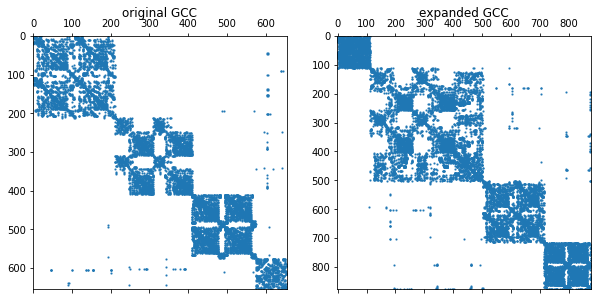

In [60]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
plt.title('original GCC')
plt.spy(clustered_adjacencies[0], markersize=1)
fig.add_subplot(1, 2, 2)
plt.title('expanded GCC')
plt.spy(clustered_adjacencies[1], markersize=1)
plt.show()

In [61]:
accuracy_original = pd.DataFrame(accuracies[0], 
                                 ['colleague', 'family','congregate','contact'], 
                                 ['cluster1','cluster2','cluster3','cluster4'])

accuracy_expanded = pd.DataFrame(accuracies[1], 
                                 ['colleague', 'family','congregate','contact'], 
                                 ['cluster1','cluster2','cluster3','cluster4'])

In [62]:
print('K-means clustering in original network')
display(accuracy_original)
print('\nK-means clustering in expanded network')
display(accuracy_expanded)

K-means clustering in original network


,cluster1,cluster2,cluster3,cluster4
colleague,0.42,0.16,0.33,0.09
family,0.35,0.06,0.00,0.59
congregate,0.00,0.94,0.00,0.06
contact,0.30,0.25,0.21,0.24



K-means clustering in expanded network


,cluster1,cluster2,cluster3,cluster4
colleague,0.00,0.33,0.37,0.30
family,0.87,0.09,0.04,0.00
congregate,0.00,1.00,0.00,0.00
contact,0.00,0.57,0.28,0.16


Looking at the clustering accuracy in our expanded network, we can observe that it is comparable to the accuracy we obtained in Milestone 3. However, one significant improvement is that k-means clustering nearly perfectly predicted the family cluster. This indicates that the added edges in our expanded network have altered the connectivity in a way that has grouped the family relations and separated them from the rest of the network.

### e. Network analysis

We now analyse how the newly added relations have impacted the properties of the terrorist network, potentially revealing its true strength

In [63]:
graph_dual = nx.from_numpy_matrix(adjacency_dual)
graph_dual_exp = nx.from_numpy_matrix(adjacency_dual_expanded)

In [64]:
print('Original data:')
print(f'Number of connected components: {nx.number_connected_components(graph_dual)}')
componentSizes = []
for component in nx.connected_components(graph_dual):
    componentSizes.append(len(component))
print(f'# of elements of connected components {componentSizes}')

print('\nExpanded data:')
print(f'Number of connected components: {nx.number_connected_components(graph_dual_exp)}')
componentSizes_exp = []
for component in nx.connected_components(graph_dual_exp):
    componentSizes_exp.append(len(component))
print(f'# of elements of connected components {componentSizes_exp}')

Original data:
Number of connected components: 13
# of elements of connected components [183, 3, 2, 9, 3, 3, 2, 2, 3, 3, 5, 18, 8]

Expanded data:
Number of connected components: 9
# of elements of connected components [209, 9, 3, 3, 2, 2, 3, 5, 8]


In [65]:
dualGCC = max(nx.connected_component_subgraphs(graph_dual), key=len)
dualGCCexp = max(nx.connected_component_subgraphs(graph_dual_exp), key=len)

In [66]:
print('Original data:')
print(f'Diameter of giant connected component: {nx.diameter(dualGCC)}')
print(f'Average shortest path of giant connected component: {nx.average_shortest_path_length(dualGCC)}')

print('\nExpanded data:')
print(f'Diameter of giant connected component: {nx.diameter(dualGCCexp)}')
print(f'Average shortest path of giant connected component: {nx.average_shortest_path_length(dualGCCexp)}')      

Original data:
Diameter of giant connected component: 13
Average shortest path of giant connected component: 5.696811385335976

Expanded data:
Diameter of giant connected component: 10
Average shortest path of giant connected component: 4.7557508281192495


We can observe that in general the connectivity of the graph has improved (as expected). The number of connected components has reduced, as the largest connected components in our original graph have merged. Additionally, although the largest component has increased in size, its diameter and average shortest path have gotten smaller. There is an average of 5 terrorists between each pair of terrorists now as opposed to 6.

### d. Identification of most wanted terrorist

Finally, we wish to identify the top targets for anti-terrorist campaigns. More precisely, we aim pinpoint the terrorist that if eliminated would cause most damage to the network and be disruptive to terrorist operations. We first look at the most obvious measure: terrorist degrees in the dual graphs for both the original and expanded network.

In [67]:
#select top 10 terrorist degrees in both graphs
X = 10
targets = []
for g in [graph_dual, graph_dual_exp]:
    mostWanted = []
    
    degreesDict = dict(nx.degree(g))
    topTerroristIDs = sorted(degreesDict, key=degreesDict.get, reverse=True)[:X]
    
    maxDegrees = []
    for i in topTerroristIDs: 
        maxDegrees.append(degreesDict[i])
    
    mostWanted.append(topTerroristIDs)
    mostWanted.append(list(terrorists.iloc[topTerroristIDs, 2]))
    mostWanted.append(maxDegrees)
    targets.append(mostWanted)

In [68]:
mostConnectedTerrorists_orig = pd.DataFrame(np.array(targets[0]).T)
mostConnectedTerrorists_exp = pd.DataFrame(np.array(targets[1]).T)
mostConnectedTerrorists_orig = mostConnectedTerrorists_orig.rename(columns={0:'ID', 1:'Name',2:'Degree'})
mostConnectedTerrorists_exp = mostConnectedTerrorists_exp.rename(columns={0:'ID', 1:'Name',2:'Degree'})

Looking at the top 10 degrees in both graphs, we can see that some names appear in both lists. However, the striking observation is that the highest degree in the expanded dual graph (Habib Zacarias Moussaoui) is a terrorist who was previously not part of the most connected terrorists. This is the case for a number of terrorists, which highlights the importance of looking at alternative terrorist networks in order to identify our target.

In [69]:
print('Top degrees in original network')
display(mostConnectedTerrorists_orig)
print('\nTop degrees in expanded network')
display(mostConnectedTerrorists_exp)

Top degrees in original network


,ID,Name,Degree
0,70,Abu_Khaled,22
1,225,KhaledMashal,20
2,220,AbbasSayyed,18
3,20,Mustafa_Kamel,17
4,4,Amar_Makhulif,16
5,67,Mohammad_Sidique_Khan,16
6,69,Mohammad_Bouyeri,16
7,71,Jason_Walters,16
8,72,Samir_Azzouz,16
9,73,Abdelhamid_Bouchema,16



Top degrees in expanded network


,ID,Name,Degree
0,9,Habib_Zacarias_Moussaoui,24
1,4,Amar_Makhulif,23
2,70,Abu_Khaled,22
3,8,Fateh_Kamel,21
4,6,Djamel_Beghal,20
5,225,KhaledMashal,20
6,36,Yacine_Akhnouche,19
7,76,Nouredine_el_Fahtni,18
8,220,AbbasSayyed,18
9,20,Mustafa_Kamel,17


Perhaps a more informative metric to compute is the betweeness centrality for each vertex. It provides a way of detecting the amount of influence a node has over the flow of information in a network. Below we compute the betweenness centrality of each node, which for a node v is the sum of the fraction of all-pairs shortest paths that pass through v. We select the top 10 for both the original and expanded dual.

In [70]:
centralTerrorists = []
centralityDegrees = []
for g in [graph_dual, graph_dual_exp]:
    centralDict = nx.betweenness_centrality(g)
    centralNodes = sorted(centralDict, key=centralDict.get, reverse=True)[:10]
    centralityNodeDegrees = []
    for i in centralNodes: 
        centralityNodeDegrees.append(centralDict[i])
    centralTerrorists.append(centralNodes)
    centralityDegrees.append(centralityNodeDegrees)

In [71]:
centralTerrorists_orig = pd.DataFrame(np.stack((centralTerrorists[0],
                                                np.array(terrorists.iloc[centralTerrorists[0],2]),
                                                centralityDegrees[0]),axis=1))

centralTerrorists_exp = pd.DataFrame(np.stack((centralTerrorists[1],
                                               np.array(terrorists.iloc[centralTerrorists[1],2]),
                                               centralityDegrees[1]),axis=1))

centralTerrorists_orig = centralTerrorists_orig.rename(columns={0:'ID', 1:'Name', 2:'Close centrality'})
centralTerrorists_exp = centralTerrorists_exp.rename(columns={0:'ID', 1:'Name', 2:'Close centrality'})

In [72]:
print(f'Top {len(centralTerrorists_orig)} betweenness centrality terrorists:')
display(centralTerrorists_orig)

print(f'Top {len(centralTerrorists_exp)} central terrorists:')
display(centralTerrorists_exp)

Top 10 betweenness centrality terrorists:


,ID,Name,Close centrality
0,39,OBL,0.254749
1,4,Amar_Makhulif,0.212159
2,110,2005/09/08/04:39:17#,0.169383
3,134,2005/11/04/20:40:21#,0.121702
4,104,2005/08/23/02:24:06#,0.115213
5,232,Zarqawi,0.109175
6,23,Omar_Mahmoud_Othman,0.10061
7,38,AhmedRessam,0.0927634
8,70,Abu_Khaled,0.0903309
9,17,Mohammed_el-Amir_Awad_el-Sayed_Atta,0.08434


Top 10 central terrorists:


,ID,Name,Close centrality
0,232,Zarqawi,0.240272
1,23,Omar_Mahmoud_Othman,0.197767
2,110,2005/09/08/04:39:17#,0.151197
3,39,OBL,0.116817
4,198,2006/02/15/18:45:00#,0.116315
5,111,2005/09/08/04:55:32#,0.111265
6,209,2006/03/28/16:33:37#,0.110451
7,4,Amar_Makhulif,0.0956601
8,8,Fateh_Kamel,0.0796619
9,134,2005/11/04/20:40:21#,0.0727851


Finally, we also identify the articulation points in both of our networks. An articulation point is a vertex in a graph which if removed would increase the number of connected components. Hence an articulation point connects two or more components and represents a vulnerability in a network. Specifically, we look at those articulation points that, if removed, split a component into 3 or more disconnected components or at least disconnect 5 terrorists from the the given component.

In [73]:
oldComponents = []
newComponents = []
ap_terrorists = []

for g in [[graph_dual, componentSizes], [graph_dual_exp, componentSizes_exp]]:

    articulations = list(nx.articulation_points(g[0]))

    components = []
    splits = []
    ap_t = []

    for i in articulations:
        temp_graph = g[0].copy()
        temp_graph.remove_node(i)

        newCompSizes = []
        for component in nx.connected_components(temp_graph):
            newCompSizes.append(len(component))

        dummy1 = newCompSizes.copy()
        dummy2 = g[1].copy()

        for n in newCompSizes:
            if n in dummy2:
                dummy1.remove(n)
                dummy2.remove(n)

        if len(dummy1) == 2:
            if dummy1[0] >= 5 and dummy1[1] >= 5:
                components.append(dummy2[0])
                splits.append(dummy1)
                ap_t.append(i)
        else:
            components.append(dummy2[0])
            splits.append(dummy1)
            ap_t.append(i)
            
    oldComponents.append(components)
    newComponents.append(splits)
    ap_terrorists.append(ap_t)

In [74]:
articulationPoints_orig = pd.DataFrame(np.stack((ap_terrorists[0],
                                                 np.array(terrorists.iloc[ap_terrorists[0],2]),
                                                 oldComponents[0],
                                                 newComponents[0]), axis=1))

articulationPoints_exp = pd.DataFrame(np.stack((ap_terrorists[1],
                                                np.array(terrorists.iloc[ap_terrorists[1],2]),
                                                oldComponents[1],
                                                newComponents[1]), axis=1))

articulationPoints_orig = articulationPoints_orig.rename(columns={0:'ID',1:'Name',2:'Component Size',3:'Split'})
articulationPoints_exp = articulationPoints_exp.rename(columns={0:'ID',1:'Name',2:'Component Size',3:'Split'})

In [75]:
display(articulationPoints_orig)
display(articulationPoints_exp)

,ID,Name,Component Size,Split
0,70,Abu_Khaled,183,"[166, 16]"
1,134,2005/11/04/20:40:21#,183,"[160, 22]"
2,232,Zarqawi,183,"[174, 7, 1]"
3,37,Zain_al-Abidin_Mohd_Hussein,183,"[170, 10, 2]"
4,8,Fateh_Kamel,183,"[175, 7]"
5,38,AhmedRessam,183,"[170, 11, 1]"
6,20,Mustafa_Kamel,183,"[179, 1, 1, 1]"
7,39,OBL,183,"[180, 1, 1]"
8,213,Zawahiri,183,"[7, 171, 4]"
9,0,Abdel_Qader_Mahmoud_Es_Sayed,183,"[176, 6]"


,ID,Name,Component Size,Split
0,232,Zarqawi,209,"[182, 7, 19]"
1,209,2006/03/28/16:33:37#,209,"[191, 17]"
2,198,2006/02/15/18:45:00#,209,"[190, 18]"
3,20,Mustafa_Kamel,209,"[205, 1, 1, 1]"
4,39,OBL,209,"[206, 1, 1]"


So far we have narrowed down our list of terrorists based on their degree, betweeness centrality and whether they act as articulation points. We have done this in both the original and expanded dual networks. For each of the networks, we identify below those terrorists that have at least achieved a high score in two of the three metrics above.

In [76]:
DC_orig = list(set(mostConnectedTerrorists_orig.iloc[:,0].astype(int)) & set(centralTerrorists_orig.iloc[:,0]))
DA_orig = list(set(mostConnectedTerrorists_orig.iloc[:,0].astype(int)) & set(articulationPoints_orig.iloc[:,0]))
AC_orig = list(set(articulationPoints_orig.iloc[:,0]) & set(centralTerrorists_orig.iloc[:,0]))
print('Terrorists appeared in the top:')
print('Degree & Centrality:', DC_orig)
print('Degree & Articulation:', DA_orig)
print('Articulation & Centrality:', AC_orig)

Terrorists appeared in the top:
Degree & Centrality: [4, 70]
Degree & Articulation: [20, 70]
Articulation & Centrality: [38, 70, 232, 134, 39]


In [77]:
DC_exp = list(set(mostConnectedTerrorists_exp.iloc[:,0].astype(int)) & set(centralTerrorists_exp.iloc[:,0]))
DA_exp = list(set(mostConnectedTerrorists_exp.iloc[:,0].astype(int)) & set(articulationPoints_exp.iloc[:,0]))
AC_exp = list(set(articulationPoints_exp.iloc[:,0]) & set(centralTerrorists_exp.iloc[:,0]))
print('Terrorists appeared in the top:')
print('Degree & Centrality:', DC_exp)
print('Degree & Articulation:', DA_exp)
print('Articulation & Centrality:', AC_exp)

Terrorists appeared in the top:
Degree & Centrality: [8, 4]
Degree & Articulation: [20]
Articulation & Centrality: [232, 209, 198, 39]


Given the filtered lists of terrorists above, we selected the intersection of the two lists:
-  4, 20, 39, 232

Additionally we selected an extra terrorist from each list to get the following:
- Targets from original network: 4, 20, 39, 232, 70
- Targets from expanded network: 4, 20, 39, 232, 8

Finally, now that we have a top 5 list from each network, we determine the most wanted terrorist by analysing the propagation of information from each terrorist in its respective graph. We do this by placing a dirac on each terrorist and using a heat kernel visualise how the signal spreads over t = 200. The comparison is presented in the cells below

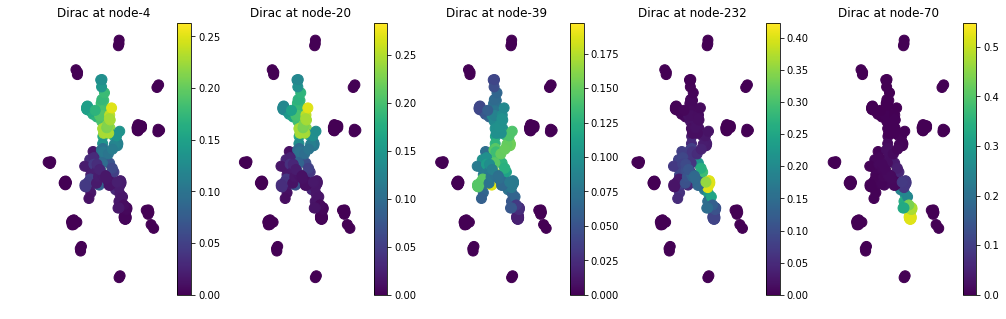

In [78]:
dual_gsp = pg.graphs.Graph(adjacency_dual)
dual_gsp.compute_fourier_basis()

dual_gsp.set_coordinates('spring')

fig = plt.figure(figsize=(17, 5))

g = pg.filters.Heat(dual_gsp, tau = 200)  # The heat kernel to be localized
SOURCE = [4, 20, 39, 232, 70]  # node to localize the heat kernel

for i in range(len(SOURCE)):
    s_localized = g.localize(SOURCE[i])
    ax = fig.add_subplot(1, len(SOURCE), i+1)
    dual_gsp.plot_signal(s_localized, colorbar=True, ax=ax)
    title = r'Dirac at node-{}'.format(SOURCE[i])
    ax.set_title(title)
    ax.set_axis_off()

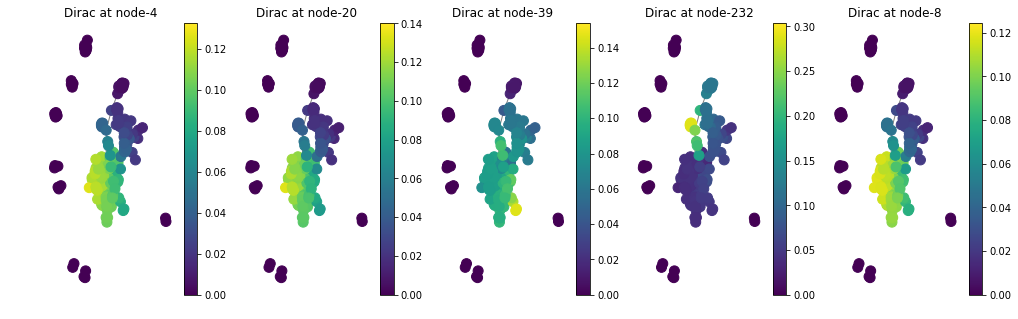

In [79]:
dual_exp_gsp = pg.graphs.Graph(adjacency_dual_expanded)
dual_exp_gsp.compute_fourier_basis()

dual_exp_gsp.set_coordinates('spring')

fig = plt.figure(figsize=(17, 5))

g = pg.filters.Heat(dual_exp_gsp, tau = 200)  # The heat kernel to be localized
SOURCE = [4, 20, 39, 232, 8]  # node to localize the heat kernel

for i in range(len(SOURCE)):
    s_localized = g.localize(SOURCE[i])
    ax = fig.add_subplot(1, len(SOURCE), i+1)
    dual_exp_gsp.plot_signal(s_localized, colorbar=True, ax=ax)
    title = r'Dirac at node-{}'.format(SOURCE[i])
    ax.set_title(title)
    ax.set_axis_off()

By analysing the how the dirac signal spreads from each terrorist, we can see how quickly information would spread across the network if a given terrorist had to share information. Looking at both the original and expanded graph, terrorist number 39 consistently performs well indicating that he is our high value target. 

In [80]:
print(terrorists.iloc[39])

url_index    http://profilesinterror.mindswap.org/document/...
num_index                                                   39
name                                                       OBL
Name: 39, dtype: object


Considering that this our most wanted terrorist, it is safe to assume that he should probably be at the head of a terrorist organisation. Hence, we look at the organizational structure in our graph emanating from this individual and observe that he is in a position where he can reach any fellow terrorist in his connected component in a maximum of 7 steps

In [81]:
spreadDict = nx.single_source_shortest_path(graph_dual_exp, source=39, cutoff=None)
spreadList = list(spreadDict.values())
nLayers = len(spreadList[-1])
layers = []
nextLayer = []

for a in range(nLayers+1):
    for i in spreadList:
        if len(i) == a:
            nextLayer.append(i[-1])
    layers.append(nextLayer)
    nextLayer = []
layers.remove([])

/anaconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


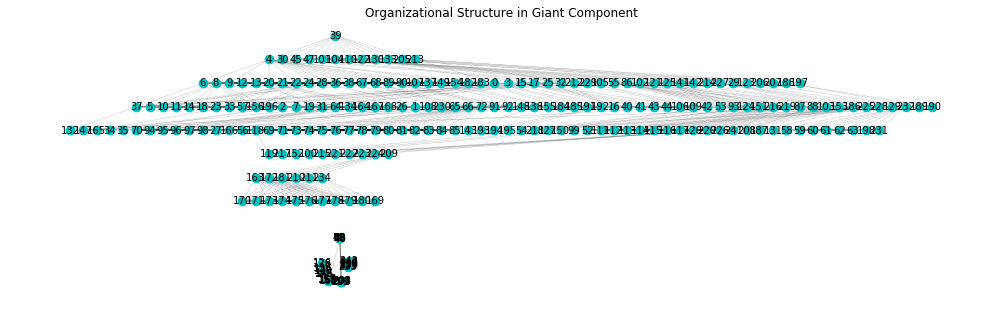

In [82]:
nodePos = nx.circular_layout(graph_dual_exp)
nodePosList = list(nodePos.values())

fig = plt.figure(figsize=(17, 5))
ax = fig.add_subplot(1, 1, 1)

for i in layers:
    lenLayer = len(i)
    for j in range(lenLayer):
        if layers.index(i) > 4:
            nodePos[i[j]] = [j-layers.index(i), len(layers)-layers.index(i)+1.5]
        else:
            nodePos[i[j]] = [j-layers.index(i)*5, len(layers)-layers.index(i)+1.5]

nx.draw_networkx(graph_dual, with_labels=True, ax=ax, pos=nodePos, node_color='c',
                 edge_color='black', node_shape='.', width = 0.1, font_size=10)

ax.set_title('Organizational Structure in Giant Component')
ax.set_axis_off()

plt.show()

## III. Conclusion
In summary, reconstructing the data has allowed us to look at the terrorist relations network from different perspectives. By creating the Dual Graph from the original relationship graph, we were able to predict the existence of relations that are not publicly known based on the similarity of node features. Reverting this expanded network back into a relationship graph format and learning the labels for the new relationships, we observed that this had a positive impact on the spectral clustering accuracy. Specifically, using spectral clustering, we managed to exclusively group the majority of family terrorist relations into a cluster. On the other hand, the Expanded Dual Graph allowed us to highlight the difference in threat between the observed and the ‘true’ terrorist network. It also shed light on new terrorists that could be targeted compared to those terrorists that are central to the original network. Subsequently, we were able to validate the importance of a single terrorist (Osame Bin Laden) in both networks by analysing the spread of a signal emanated from his respective node in the network compared to other central nodes. Finally, reviewing his connections in the expanded terrorist network revealed an organisational structure in his respective connected component that is comparable to a terrorist organization.